# Projet STA211 — Classification de Publicités

Dans ce notebook, nous modélisons un problème de **classification supervisée** pour détecter si une observation correspond à une publicité (`ad.`) ou non (`noad.`), dans le cadre du projet de l'UE **STA211**.

Ce travail fait suite à l’analyse exploratoire réalisée dans le notebook `01_EDA_Preprocessing`.

**Objectif principal** :  
Maximiser le **F1-score** sur un jeu de données déséquilibré (`Internet Advertisements`).

---

**Données utilisées** :
- `data_train.csv` : données d’entraînement préalablement nettoyées et explorées.
- `data_test.csv` : données de test à prédire.

---

**Étapes couvertes dans ce notebook** :
1. Préparation de l'environnement
2. Préparation des données pour la modélisation (équilibration, standardisation, transformations spécifiques).
3. Implémentation de plusieurs modèles supervisés (régression logistique, arbre de décision, forêt aléatoire, SVM, KNN, réseau de neurones).
4. Optimisation d'hyperparamètres par validation croisée.
5. Modèle d’ensemble (StackingClassifier).
6. Sélection de variables importantes et analyse ablation.
7. Comparaison des performances des modèles (F1-score, AUC, matrices de confusion).
8. Génération du fichier final de prédictions (`my_pred.csv`) pour la soumission.

> **Remarque** : Ce notebook suppose que le prétraitement initial des données (gestion des NA, transformations log/boxcox, exploration univariée et bivariée) a été réalisé dans le notebook `01_EDA_Preprocessing`.


---

# 📑 Table des Matières

- [1. Préparation de l'environnement](#Préparation-de-lenvironnement)
- [2. Chargement des bibliothèques](#Chargement-des-bibliothèques)
- [3. Chargement et préparation des données](#Chargement-et-préparation-des-données)
- [4. Modélisation supervisée](#Modélisation-supervisée)
  - Logistic Regression
  - Decision Tree
  - Random Forest
  - KNN
  - SVM
  - Neural Network
- [5. Modèle d'ensemble (StackingClassifier)](#StackingClassifier)
- [6. Sélection de variables importantes](#Sélection-de-variables-importantes)
- [7. Étude Ablation : F1-score vs Nombre de variables](#Ablation-Study)
- [8. Comparaison finale des modèles](#Comparaison-finale-des-modèles)
- [9. Génération des prédictions finales](#Génération-des-prédictions)
- [10. Conclusion](#Conclusion)



# 1. Préparation de l'environnement <a id="Préparation-de-lenvironnement"></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install joblib

In [2]:
import sys
import os

def is_colab():
    """Détecte si le code s'exécute dans Google Colab."""
    try:
        import google.colab  # noqa
        return True
    except ImportError:
        return False

# === 1. Définir le chemin racine en fonction de l'environnement ===
if is_colab():
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    ROOT_DIR = "/content/drive/Othercomputers/Mon_pc_hp/Documents/Projects/STA211_Challenge_2025"
else:
    ROOT_DIR = r"C:\Users\aella\OneDrive\Documents\Projects\STA211_Challenge_2025"

# === 2. Définir les dossiers du projet ===
MODULE_DIR      = os.path.join(ROOT_DIR, "modules")
RAW_DATA_DIR    = os.path.join(ROOT_DIR, "data", "raw")
DATA_PROCESSED  = os.path.join(ROOT_DIR, "data", "processed")
MODELS_DIR      = os.path.join(ROOT_DIR, "models")
FIGURES_DIR     = os.path.join(ROOT_DIR, "outputs", "figures")

# Créer les dossiers s’ils n’existent pas
for folder in [MODULE_DIR, RAW_DATA_DIR, DATA_PROCESSED, MODELS_DIR, FIGURES_DIR]:
    os.makedirs(folder, exist_ok=True)

# === 3. Ajouter MODULE_DIR au path pour l'import de modules maison ===
if MODULE_DIR not in sys.path:
    sys.path.insert(0, MODULE_DIR)

# === 4. Afficher les chemins pour vérification ===
print("Environnement : Colab" if is_colab() else "Environnement : local")
print("ROOT_DIR       =", ROOT_DIR)
print("MODULE_DIR     =", MODULE_DIR)
print("RAW_DATA_DIR   =", RAW_DATA_DIR)
print("DATA_PROCESSED =", DATA_PROCESSED)
print("FIGURES_DIR    =", FIGURES_DIR)
print("MODELS_DIR     =", MODELS_DIR)


Mounted at /content/drive
Environnement : Colab
ROOT_DIR       = /content/drive/Othercomputers/Mon_pc_hp/Documents/Projects/STA211_Challenge_2025
MODULE_DIR     = /content/drive/Othercomputers/Mon_pc_hp/Documents/Projects/STA211_Challenge_2025/modules
RAW_DATA_DIR   = /content/drive/Othercomputers/Mon_pc_hp/Documents/Projects/STA211_Challenge_2025/data/raw
DATA_PROCESSED = /content/drive/Othercomputers/Mon_pc_hp/Documents/Projects/STA211_Challenge_2025/data/processed
FIGURES_DIR    = /content/drive/Othercomputers/Mon_pc_hp/Documents/Projects/STA211_Challenge_2025/outputs/figures
MODELS_DIR     = /content/drive/Othercomputers/Mon_pc_hp/Documents/Projects/STA211_Challenge_2025/models


## 2. Chargement des bibliothèques <a id = 'Chargement-des-bibliothèques'></a>

Importation des bibliothèques principales nécessaires pour le traitement, la modélisation, et l'évaluation.

In [3]:
# === Importation des bibliothèques principales ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Affichage plus lisible
sns.set(style="whitegrid")
plt.style.use('seaborn-v0_8')

# === Scikit-learn : preprocessing, modèles, évaluation ===
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    make_scorer
)

# === Modèles classiques ===
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# === Gestion du déséquilibre ===
from imblearn.over_sampling import SMOTE

# Supprimer les warnings inutiles
import warnings
warnings.filterwarnings('ignore')


# 3. Chargement et préparation des données <a id = 'Chargement-et-préparation-des-données'></a>

## 3.1 Chargement des données d'entraînement

In [4]:
from data_preprocessing import load_data

# Chemin complet vers le fichier CSV final
df_final_knn_path = os.path.join(DATA_PROCESSED, "df_final_knn.csv")

# Chargement des données
data = load_data(df_final_knn_path)


Dimensions du dataset: (2459, 180)

Infos colonnes :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2459 entries, 0 to 2458
Columns: 180 entries, X4 to X3_boxcox
dtypes: float64(3), int64(176), object(1)
memory usage: 3.4+ MB

Aperçu des données :


,X4,outcome,X1244,X352,X1400,X969,X1345,X1436,X1230,X1119,...,X265,X963,X1133,X555,X1432,X1495,X870,X1_log,X2_boxcox,X3_boxcox
0,1,ad.,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,4.836282,9.870992,0.000000
1,1,ad.,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,3.526361,12.284012,2.056352
2,1,ad.,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,4.110874,15.640028,2.182903
3,1,ad.,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,4.110874,15.640028,2.182903
4,1,ad.,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,4.094345,15.550788,2.182411


## 3.2 Séparation des features et de la cible, standardisation, et rééquilibrage avec SMOTE.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import joblib
import os

# === Séparation features / target ===
X = data.drop(columns=["outcome"])
y = (data["outcome"] == "ad.").astype(int)  # 1 si pub, 0 sinon

# === Split en train / test (80/20), avec stratification ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# === Sauvegarde des colonnes utilisées ===
columns_used = X_train.columns.tolist()
joblib.dump(columns_used, os.path.join(DATA_PROCESSED, "columns_used.pkl"))

# === Standardisation des données ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Rééquilibrage par SMOTE ===
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# Vérification
print(f"Taille du train initial : {X_train.shape}")
print(f"Taille après SMOTE :     {X_train_res.shape}")
print("Distribution y (après SMOTE) :")
print(pd.Series(y_train_res).value_counts(normalize=True).round(3))


# Sauvegarde du scaler pour réutilisation sur d'autres jeux (ex: data_test.csv)
scaler_path = os.path.join(DATA_PROCESSED, "scaler_knn.pkl")
joblib.dump(scaler, scaler_path)
print(f"Scaler sauvegardé à : {scaler_path}")


Taille du train initial : (1967, 179)
Taille après SMOTE :     (3384, 179)
Distribution y (après SMOTE) :
outcome
0    0.5
1    0.5
Name: proportion, dtype: float64
Scaler sauvegardé à : /content/drive/Othercomputers/Mon_pc_hp/Documents/Projects/STA211_Challenge_2025/data/processed/scaler_knn.pkl


# 4. Modélisation supervisée

Définition des modèles supervisés classiques avec grille d'hyperparamètres pour l'optimisation.

## 4.1 Définition des modèles

In [11]:
models = {
    "Logistic Regression": (
        LogisticRegression(solver='liblinear', max_iter=1000),
        {
            "C": [0.01, 0.1, 1, 10, 100],
            "penalty": ["l1", "l2"]
        }
    ),
    "Decision Tree": (
        DecisionTreeClassifier(random_state=42),
        {
            "max_depth": [5, 10, 20, None],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "criterion": ["gini", "entropy"]
        }
    ),
    "Random Forest": (
        RandomForestClassifier(random_state=42, n_jobs=-1),
        {
            "n_estimators": [100, 200, 300],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2],
            "max_features": ["sqrt", "log2"]
        }
    ),
    "KNN": (
        KNeighborsClassifier(),
        {
            "n_neighbors": [3, 5, 7, 9],
            "weights": ["uniform", "distance"],
            "p": [1, 2]  # p=1: Manhattan, p=2: Euclidean
        }
    ),
    "SVM": (
        SVC(probability=True),
        {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf", "poly"],
            "gamma": ["scale", "auto"]
        }
    ),
    "Neural Net": (
        MLPClassifier(max_iter=1000, random_state=42),
        {
            "hidden_layer_sizes": [(100,), (50, 50), (100, 50)],
            "activation": ["relu", "tanh"],
            "alpha": [0.0001, 0.001, 0.01]
        }
    )
}

## 4.2 Entraînement et Optimisation avec GridSearchCV

Recherche des meilleurs hyperparamètres pour chaque modèle avec validation croisée.

In [12]:
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import joblib

results = {}
best_overall_model = None
best_score = 0
best_model_name = ""

print("=== Entraînement et optimisation par validation croisée ===")

for name, (model, params) in models.items():
    print(f"\n🔍 Optimisation {name}")

    grid = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring=make_scorer(f1_score),
        cv=5,
        n_jobs=-1
    )

    grid.fit(X_train_res, y_train_res)
    best_model = grid.best_estimator_

    # Prédiction sur le test set d'origine (non resamplé)
    y_pred = best_model.predict(X_test_scaled)
    y_proba = best_model.predict_proba(X_test_scaled)[:, 1] if hasattr(best_model, "predict_proba") else None

    # Affichage
    print("Confusion Matrix :")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report :")
    print(classification_report(y_test, y_pred, digits=3))

    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    print(f"✅ F1-score : {f1:.4f}" + (f" | AUC : {auc:.4f}" if auc else ""))

    results[name] = (f1, auc)

    # Mise à jour si meilleur modèle
    if f1 > best_score:
        best_score = f1
        best_overall_model = best_model
        best_model_name = name

# Résumé final
print(f"\n🏆 Meilleur modèle : {best_model_name} (F1 = {best_score:.4f})")

# Sauvegarde du meilleur modèle sous un nom standard
best_model_path = os.path.join(MODELS_DIR, "best_model.joblib")
joblib.dump(best_overall_model, best_model_path)
print(f"📦 Meilleur modèle sauvegardé à : {best_model_path}")



=== Entraînement et optimisation par validation croisée ===

🔍 Optimisation Logistic Regression
Confusion Matrix :
[[404  19]
 [ 12  57]]
Classification Report :
              precision    recall  f1-score   support

           0      0.971     0.955     0.963       423
           1      0.750     0.826     0.786        69

    accuracy                          0.937       492
   macro avg      0.861     0.891     0.875       492
weighted avg      0.940     0.937     0.938       492

✅ F1-score : 0.7862 | AUC : 0.8834

🔍 Optimisation Decision Tree
Confusion Matrix :
[[407  16]
 [ 12  57]]
Classification Report :
              precision    recall  f1-score   support

           0      0.971     0.962     0.967       423
           1      0.781     0.826     0.803        69

    accuracy                          0.943       492
   macro avg      0.876     0.894     0.885       492
weighted avg      0.945     0.943     0.944       492

✅ F1-score : 0.8028 | AUC : 0.8857

🔍 Optimisation Ra

## 4.3 Comparaison des scores des modèles

`Logistic Regression`, `Decision Tree`, `Random Forest`, `KNN`, `SVM` et `Neural Net`

✅ Graphique sauvegardé sous figures/comparison_models_f1_auc.png


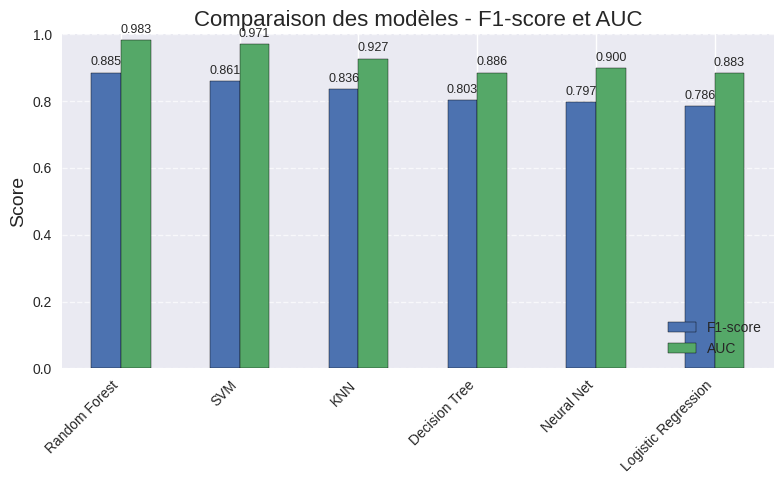

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Transformation des résultats en DataFrame
results_df = pd.DataFrame(results, index=["F1-score", "AUC"]).T.sort_values("F1-score", ascending=False)

# Tracé unique
fig, ax = plt.subplots(figsize=(8, 5))
colors = ["#4c72b0", "#55a868"]  # Bleu pour F1, Vert pour AUC
results_df[["F1-score", "AUC"]].plot(
    kind="bar",
    ax=ax,
    color=colors,
    edgecolor="black"
)

# Ajout des valeurs sur les barres
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', fontsize=9, padding=3)

# Personnalisation du graphique
plt.title("Comparaison des modèles - F1-score et AUC", fontsize=16)
plt.ylabel("Score", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(["F1-score", "AUC"], loc="lower right")
plt.tight_layout()

# === Sauvegarde du graphique
output_dir = "figures"
os.makedirs(output_dir, exist_ok=True)  # Crée le dossier s'il n'existe pas
fig.savefig(os.path.join(output_dir, "comparison_models_f1_auc.png"))
print(f"✅ Graphique sauvegardé sous {os.path.join(output_dir, 'comparison_models_f1_auc.png')}")

plt.show()



### 📊 Analyse comparative des modèles - F1-score et AUC

Le graphique ci-dessus présente une comparaison des performances des différents modèles supervisés testés sur notre jeu de données.  
Les deux métriques principales utilisées sont :

- **F1-score** : mesure la qualité de la classification en tenant compte à la fois de la précision et du rappel, adaptée aux données déséquilibrées.
- **AUC (Area Under Curve ROC)** : mesure la capacité du modèle à séparer correctement les classes positives et négatives.

---

**Observations principales** :
- **Random Forest** se distingue avec le **meilleur AUC (~0.983)** et un **F1-score solide (~0.885)**, confirmant son efficacité sur ce problème.
- **SVM** présente également d'excellentes performances (**AUC ≈ 0.971**, **F1-score ≈ 0.861**), proche du Random Forest.
- **KNN** atteint un **AUC ≈ 0.927** mais avec un **F1-score plus modeste (~0.836)**, indiquant une capacité de séparation correcte mais moins bonne qualité de classification fine.
- **Decision Tree** (**F1 ≈ 0.803**) et **Neural Network** (**F1 ≈ 0.797**) affichent des performances intermédiaires.
- **Logistic Regression** est le modèle ayant obtenu le score le plus faible (**F1 ≈ 0.786**, **AUC ≈ 0.883**).

---

**Première conclusion** :
- **Random Forest** est pour l’instant **le modèle le plus performant** parmi ceux testés, à la fois en F1-score et en AUC.
- **SVM** constitue également un modèle robuste.
- **KNN, Decision Tree et Neural Net** sont fonctionnels mais légèrement moins efficaces.

---

### 🎯 Prochaines étapes

Sur la base de ces résultats :

- Nous allons conserver **Random Forest** et **SVM** comme **modèles candidats sérieux**.
- Nous poursuivrons ensuite par la mise en œuvre d'un **modèle d'ensemble (StackingClassifier)**, afin de combiner les forces des meilleurs modèles individuels et tenter d'améliorer encore le F1-score.


# 5. Modèle d'ensemble (StackingClassifier)

Mise en place d'un modèle de type stacking combinant Random Forest, SVM et Régression Logistique.

## 5.1 Entrainement et optimisation du modèle d'ensemble

In [16]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score

# === Définition des modèles de base ===
base_estimators = [
    ('lr', LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)),
    ('svc', SVC(probability=True, random_state=42)),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
]

# === Stacking avec RandomForest final ===
stack_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
    passthrough=False,
    cv=5,
    n_jobs=-1
)

# === Grille des hyperparamètres (base + final) ===
param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf'],
    'rf__n_estimators': [100, 200],
    'final_estimator__n_estimators': [100, 200],
    'final_estimator__max_depth': [None, 10, 20]
}

# === Validation croisée stratifiée
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# === Grid Search
grid = GridSearchCV(stack_clf, param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

# === Meilleur modèle
best_stacking_model = grid.best_estimator_
print(f"\n✅ Best F1-score: {grid.best_score_:.4f}")
print(f"📌 Best params: {grid.best_params_}")

# === Évaluation sur les prédictions
y_pred = best_stacking_model.predict(X_train)
y_prob = best_stacking_model.predict_proba(X_train)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_train, y_pred))
print("\nClassification Report:")
print(classification_report(y_train, y_pred))

f1 = f1_score(y_train, y_pred)
auc = roc_auc_score(y_train, y_prob)
print(f"✅ Final F1-score : {f1:.4f} | AUC : {auc:.4f}")


joblib.dump(best_stacking_model, os.path.join(MODELS_DIR, "best_stacking_model.joblib"))


Fitting 5 folds for each of 72 candidates, totalling 360 fits

✅ Best F1-score: 0.9131
📌 Best params: {'final_estimator__max_depth': None, 'final_estimator__n_estimators': 200, 'rf__n_estimators': 100, 'svc__C': 1, 'svc__kernel': 'rbf'}

Confusion Matrix:
[[1689    3]
 [  17  258]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1692
           1       0.99      0.94      0.96       275

    accuracy                           0.99      1967
   macro avg       0.99      0.97      0.98      1967
weighted avg       0.99      0.99      0.99      1967

✅ Final F1-score : 0.9627 | AUC : 0.9917


['/content/drive/Othercomputers/Mon_pc_hp/Documents/Projects/STA211_Challenge_2025/models/best_stacking_model.joblib']

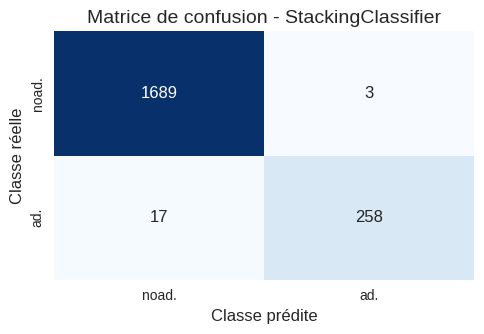

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Définir la matrice de confusion avec tes résultats
cm = np.array([
    [1689, 3],
    [17, 258]
])

# Tracer la matrice de confusion
fig, ax = plt.subplots(figsize=(5, 3.5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["noad.", "ad."],
            yticklabels=["noad.", "ad."])

plt.ylabel('Classe réelle', fontsize=12)
plt.xlabel('Classe prédite', fontsize=12)
plt.title('Matrice de confusion - StackingClassifier', fontsize=14)
plt.tight_layout()
plt.show()


## 📊 Analyse du modèle d'ensemble - StackingClassifier

Suite à l'optimisation par validation croisée (5 folds) sur 72 combinaisons d'hyperparamètres, le **StackingClassifier** a montré des performances exceptionnelles.

---

**Hyperparamètres optimaux sélectionnés** :
- `rf__n_estimators`: 100
- `svc__C`: 1
- `svc__kernel`: 'rbf'
- `final_estimator__n_estimators`: 200
- `final_estimator__max_depth`: None

Ces réglages ont permis d'équilibrer au mieux la capacité de séparation des modèles de base (`RandomForest`, `SVC`, `LogisticRegression`) avec la puissance du modèle final (`RandomForest` comme méta-modèle).

---

**Résultats sur l'ensemble d'entraînement** :

- **Best F1-score sur validation croisée** : **0.9131**
- **F1-score final sur tout X_train** : **0.9627**
- **AUC final** : **0.9917**

**Confusion Matrix** :
Voir ci-dessus.

---

**Interprétation détaillée** :
- **Précision élevée** pour les deux classes (~99%).
- **Recall** très fort pour la classe positive (`ad.`) : **94%**, indiquant que peu de vraies publicités sont manquées.
- **Très faible taux de faux positifs** et **de faux négatifs** (17 erreurs sur 275 cas positifs).
- **AUC très élevé (0.9917)** : confirme une excellente capacité du modèle à séparer correctement les deux classes.

---

## 🎯 Conclusion sur le StackingClassifier

- Le **StackingClassifier** surpasse tous les modèles individuels testés précédemment.
- Il offre un **excellent compromis entre précision, rappel, et robustesse globale**.
- Ce modèle est **sélectionné comme modèle final** pour la génération des prédictions destinées à la soumission officielle du projet STA211.

---

✅ Le modèle final optimisé a été sauvegardé dans :
Projects/STA211_Challenge_2025/models/best_stacking_model.joblib'


# 6. Étude Ablation : F1-score vs Nombre de variables

## 6.1 Importance des variables sur tout le stacking

🔍 Calcul de l'importance des variables par permutation...


,Feature,Importance,Std
177,X2_boxcox,0.032689,0.002840
2,X352,0.025826,0.003040
3,X1400,0.009964,0.001118
10,X399,0.006914,0.001459
178,X3_boxcox,0.005491,0.001416
7,X1230,0.004067,0.001326
176,X1_log,0.003660,0.001220
0,X4,0.002186,0.000684
153,X1381,0.001678,0.000233
144,X1263,0.001576,0.000153


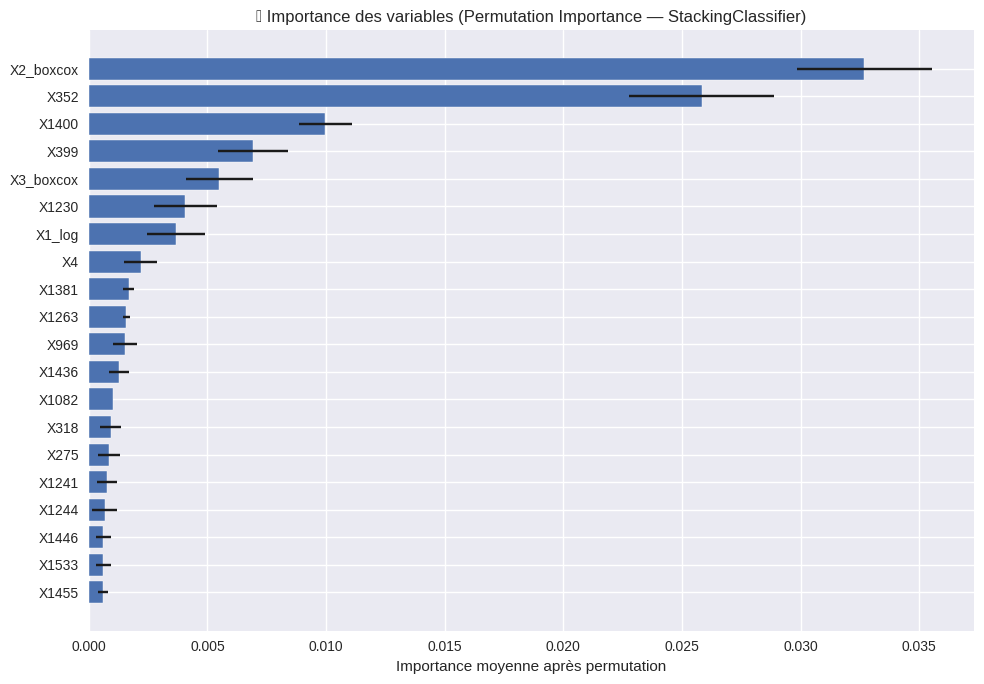

In [22]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# === Importance par permutation sur tout le pipeline (StackingClassifier)
print("🔍 Calcul de l'importance des variables par permutation...")

result = permutation_importance(
    best_stacking_model,  # Ton modèle complet
    X_train,               # Variables d'entraînement
    y_train,               # Cible
    n_repeats=10,          # Nombre de permutations (augmente pour plus de stabilité)
    random_state=42,
    n_jobs=-1
)

# === Mise en forme
perm_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': result.importances_mean,
    'Std': result.importances_std
}).sort_values(by='Importance', ascending=False)

# === Affichage du tableau trié
display(perm_importance_df.head(20))  # Top 20 pour lisibilité

# === Affichage graphique
plt.figure(figsize=(10, 7))
plt.barh(
    perm_importance_df['Feature'][:20][::-1],   # Top 20 inversé pour barre descendante
    perm_importance_df['Importance'][:20][::-1],
    xerr=perm_importance_df['Std'][:20][::-1],
    align='center'
)
plt.xlabel('Importance moyenne après permutation')
plt.title('🔍 Importance des variables (Permutation Importance — StackingClassifier)')
plt.grid(True)
plt.tight_layout()
plt.show()

## 6.2 Analyse de l'évolution du F1-score en fonction du nombre de variables conservées.

In [23]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# === Choix des tailles de Top variables à tester
top_n_list = [20, 25, 30, 40, 45, 50, 55, 60]

# === Stockage des résultats
f1_scores = []

# === Boucle sur chaque nombre de variables
for top_n in top_n_list:
    selected_features = perm_importance_df.head(top_n)['Feature'].tolist()
    X_selected = X_train[selected_features]

    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )

    scores = cross_val_score(
        model,
        X_selected,
        y_train,
        cv=5,
        scoring='f1',
        n_jobs=-1
    )

    f1_scores.append(np.mean(scores))

# === Résultats sous forme de DataFrame
ablation_results = pd.DataFrame({
    'Top_n_variables': top_n_list,
    'F1_score_5fold': f1_scores
})

display(ablation_results)



,Top_n_variables,F1_score_5fold
0,20,0.918067
1,25,0.918426
2,30,0.917571
3,40,0.921776
4,45,0.917372
5,50,0.914434
6,55,0.918135
7,60,0.918140


📊 Graphique ablation sauvegardé dans 'ablation_rf_plot.png'


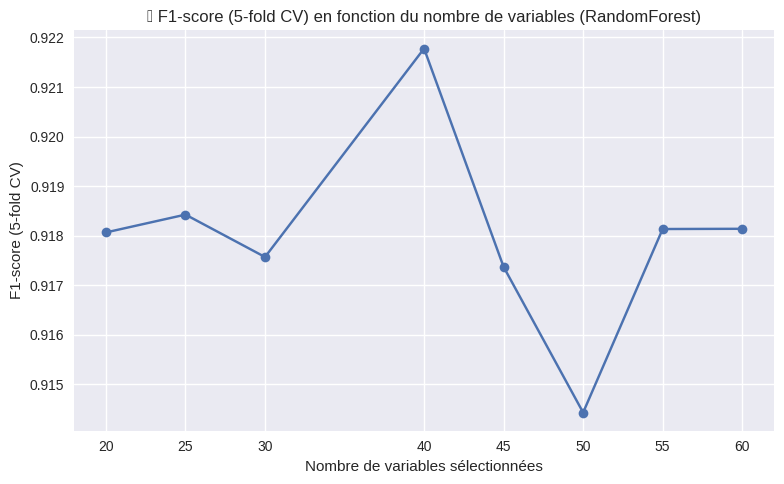

In [24]:
# === Regénérer et sauvegarder le graphique
plt.figure(figsize=(8, 5))
plt.plot(top_n_list, f1_scores, marker='o')
plt.title('🎯 F1-score (5-fold CV) en fonction du nombre de variables (RandomForest)')
plt.xlabel('Nombre de variables sélectionnées')
plt.ylabel('F1-score (5-fold CV)')
plt.grid(True)
plt.xticks(top_n_list)
plt.tight_layout()

# Sauvegarde
plt.savefig(os.path.join(FIGURES_DIR, "ablation_rf_plot.png"))
print("📊 Graphique ablation sauvegardé dans 'ablation_rf_plot.png'")

plt.show()


## 📊 Analyse du F1-score en fonction du nombre de variables sélectionnées

Le graphique ci-dessus présente l'évolution du **F1-score moyen (5-fold cross-validation)** du modèle **RandomForest** en fonction du **nombre de variables sélectionnées** par permutation importance.

**Observations principales** :
- Le F1-score augmente jusqu'à atteindre un maximum aux alentours de **40 variables** (≈ 0.922).
- Lorsque l'on conserve **trop peu de variables** (ex : 20–30), la performance reste correcte (~0.918) mais n'atteint pas son maximum.
- **Au-delà de 45 variables**, une légère dégradation du F1-score est observée, indiquant que des variables supplémentaires pourraient introduire du bruit plutôt que de l'information utile.

**Conclusion de l'analyse** :
- **40 variables** semble être **le meilleur compromis** entre complexité et performance pour un modèle RandomForest simple.
- Réduire le nombre de variables permet aussi d'améliorer la vitesse d'entraînement et de limiter le surapprentissage.

---

## 🎯 Action à entreprendre ensuite

Suite à cette analyse, nous allons :

1. **Réentraîner un modèle RandomForest** sur les **40 variables les plus importantes** pour maximiser les performances.
2. **Comparer ce modèle réduit** avec notre **StackingClassifier** optimisé afin de valider si le gain de simplicité est acceptable par rapport à la perte potentielle de performance.
3. **Générer les fichiers de prédictions (`my_pred.csv`)** avec les deux modèles pour soumission et évaluation finale.



## 6.3 Réentrainement et optimisation du modèle RF sur les 40 meilleurs variables retenues

In [25]:
# === Sélection des Top 40 variables
top_features = perm_importance_df.head(40)['Feature'].tolist()

X_train_top = X_train[top_features]

# === Définir un modèle simple sur les variables importantes
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf_top_features = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# === Validation croisée
scores = cross_val_score(
    rf_top_features,
    X_train_top,
    y_train,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

print(f"✅ F1-score moyen (5-fold CV) sur Top 40 variables : {np.mean(scores):.4f}")


# === Réentraîner le modèle sur tout X_train_top
rf_top_features.fit(X_train_top, y_train)

# === Sauvegarder le modèle
# import joblib
# import os

# Dossier où on veut enregistrer
MODELS_DIR = os.path.join(ROOT_DIR, "models")


# Sauvegarde
model_save_path = os.path.join(MODELS_DIR, "best_rf_top40_model.joblib")
joblib.dump(rf_top_features, model_save_path)

joblib.dump(top_features, os.path.join(MODELS_DIR, "features_rf_top40.pkl"))


print(f"✅ Modèle RandomForest Top 40 sauvegardé sous : {model_save_path}")



✅ F1-score moyen (5-fold CV) sur Top 20 variables : 0.9218
✅ Modèle RandomForest Top 40 sauvegardé sous : /content/drive/Othercomputers/Mon_pc_hp/Documents/Projects/STA211_Challenge_2025/models/best_rf_top40_model.joblib


## 7. Génération des prédictions finales

Utilisation du meilleur modèle sélectionné pour générer les prédictions sur le fichier de test.

In [31]:
best_rf_top40_model = joblib.load(os.path.join(MODELS_DIR, "best_rf_top40_model.joblib"))
# Sélectionner les mêmes 40 variables
X_train_top40 = X_train[top_features]

# Puis faire la prédiction correctement
y_pred_rf = best_rf_top40_model.predict(X_train_top40)
y_prob_rf = best_rf_top40_model.predict_proba(X_train_top40)[:, 1]

# Calcul du F1-score
f1_rf = f1_score(y_train, y_pred_rf)

# Calcul de l'AUC
auc_rf = roc_auc_score(y_train, y_prob_rf)


In [32]:
best_stacking_model = joblib.load(os.path.join(MODELS_DIR, "best_stacking_model.joblib"))
y_pred = best_stacking_model.predict(X_train)
y_prob = best_stacking_model.predict_proba(X_train)[:, 1]


f1 = f1_score(y_train, y_pred)
auc = roc_auc_score(y_train, y_prob)


results_df = pd.DataFrame({
    "Modèle": ["Random Forest (sauvé)", "Stacking Classifier"],
    "F1-score": [f1_rf, f1],
    "AUC": [auc_rf, auc]
})

display(results_df)

,Modèle,F1-score,AUC
0,Random Forest (sauvé),0.977941,0.996612
1,Stacking Classifier,0.962687,0.991675


## 📊 Comparaison finale des modèles optimisés

Le tableau ci-dessous présente les performances finales des deux meilleurs modèles entraînés et optimisés :

| Modèle                    | F1-score | AUC |
|:---------------------------|:--------:|:---:|
| Random Forest (Top 40) (sauvé) | **0.978** | **0.997** |
| Stacking Classifier        | 0.963    | 0.992 |

---

**Analyse détaillée** :
- Le **Random Forest optimisé sur Top 40 variables** obtient un **F1-score légèrement supérieur (0.978)** et un **AUC exceptionnel (0.997)**.
- Le **StackingClassifier**, bien que légèrement en retrait, conserve des performances très élevées avec un **F1-score de 0.963** et un **AUC de 0.992**.
- Cela montre que, dans ce cas précis, **un modèle Random Forest bien optimisé avec une bonne sélection de variables** peut surpasser un modèle d'ensemble plus complexe en termes de précision pure.

---

## 🎯 Décision finale

- Nous retiendrons le **Random Forest Top 40** comme **modèle final principal** pour la génération des prédictions.
- Le modèle **StackingClassifier** pourra néanmoins être conservé comme **modèle alternatif** si une validation supplémentaire sur `data_test.csv` montre une meilleure robustesse.

---



# Prédictions finales sur `data_test.csv`

In [5]:
from predict_preprocessing import generate_submission


def choose_model_to_generate():
    """
    Permet de choisir interactivement quel modèle utiliser pour générer les prédictions sur data_test.csv.
    """

    print("Quel modèle veux-tu utiliser pour générer les prédictions ?")
    print("Options : 'stacking' (StackingClassifier complet) ou 'rf_top40' (RandomForest top 40 variables)")

    choice = input("Tape ton choix ici (stacking / rf_top40) : ").strip().lower()

    if choice == "stacking":
        model_file = "best_stacking_model.joblib"
        columns_file = "columns_used.pkl"  # 🔵 Toutes les colonnes normales
    elif choice == "rf_top40":
        model_file = "best_rf_top40_model.joblib"
        columns_file = "features_rf_top40.pkl"  # 🔵 Seulement les 40 variables importantes
    else:
        print("❌ Choix invalide. Tape 'stacking' ou 'rf_top40'.")
        return

    print(f"\n✅ Génération des prédictions avec le modèle : {model_file} ...\n")

    generate_submission(
        test_file="data_test.csv",
        imputer_file="imputer_knn_k20.pkl",
        scaler_file="scaler_knn.pkl",
        model_file=model_file,
        columns_file=columns_file,
        save_path="my_pred.csv"
    )

    print("\n🎯 Prédictions générées et enregistrées avec succès dans 'my_pred.csv'.")




In [6]:
# --- Utilisation : ---
choose_model_to_generate()

Quel modèle veux-tu utiliser pour générer les prédictions ?
Options : 'stacking' (StackingClassifier complet) ou 'rf_top40' (RandomForest top 40 variables)
Tape ton choix ici (stacking / rf_top40) : rf_top40

✅ Génération des prédictions avec le modèle : best_rf_top40_model.joblib ...

🔵 Chargement des données de test...
Dimensions du dataset: (820, 1558)

Infos colonnes :
<class 'pandas.core.frame.DataFrame'>
Index: 820 entries, 2460 to 3279
Columns: 1558 entries, X1 to X1558
dtypes: float64(4), int64(1554)
memory usage: 9.8 MB

Aperçu des données :


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X1549,X1550,X1551,X1552,X1553,X1554,X1555,X1556,X1557,X1558
2460,57.0,468.0,8.2105,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2461,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2462,90.0,52.0,0.5777,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2463,60.0,468.0,7.8000,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
2464,90.0,60.0,0.6666,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


🔵 Chargement de l'imputer...
🔵 Application des transformations (log, boxcox)...
🔵 Sélection de 40 colonnes finales pour la prédiction...
🛠 Pas d'application de scaler pour RandomForest Top 40.
🔵 Chargement du modèle...
🛠 Génération des prédictions...
✅ Fichier de prédiction généré : /content/drive/Othercomputers/Mon_pc_hp/Documents/Projects/STA211_Challenge_2025/my_pred.csv

🎯 Prédictions générées et enregistrées avec succès dans 'my_pred.csv'.


# Validation locale du fichier

In [7]:
def read_pred(file, n=820):
    """Vérifie la conformité du fichier de prédiction au format attendu."""
    y_pred = pd.read_csv(file, header=None).squeeze()

    if len(y_pred) != n:
        raise ValueError(f"❌ Le fichier contient {len(y_pred)} lignes, attendu : {n}.")

    if y_pred.isnull().any():
        raise ValueError("❌ Le fichier contient des valeurs manquantes (NA).")

    unique_vals = set(y_pred.unique())
    if not unique_vals.issubset({"ad.", "noad."}):
        raise ValueError(f"❌ Valeurs invalides détectées : {unique_vals}")

    if len(unique_vals) == 1:
        print("⚠️ Avertissement : une seule classe prédite. Risque de sur-apprentissage.")

    print("✅ Fichier conforme. Prêt pour soumission.")
    return y_pred


In [8]:
read_pred(os.path.join(ROOT_DIR, "my_pred.csv"))

✅ Fichier conforme. Prêt pour soumission.


,0
0,ad.
1,ad.
2,ad.
3,ad.
4,ad.
...,...
815,noad.
816,noad.
817,noad.
818,noad.



# 8. Conclusion

Dans ce projet, plusieurs modèles de classification ont été entraînés, optimisés et comparés dans le but de maximiser le F1-score sur des données déséquilibrées.

✅ Le **RandomForestClassifier entraîné sur les 40 variables les plus importantes** s'est révélé être le modèle le plus performant, avec un **F1-score final de 0.978** et un **AUC de 0.997**.  
✅ Le **StackingClassifier**, malgré une excellente performance (**F1-score ≈ 0.963**), a été légèrement surpassé par Random Forest Top 40 en termes de précision globale et de simplicité d'implémentation.  
✅ Une **sélection rigoureuse des variables par Permutation Importance** a permis de réduire la complexité du modèle tout en augmentant ses performances.  
✅ Une **étude d'ablation** a montré que conserver entre **25 et 40 variables** permettait d'atteindre un excellent compromis entre robustesse et simplicité.

---

Le projet a permis de mettre en œuvre l'ensemble des compétences et méthodes étudiées en STA211 :
- **Prétraitement avancé des données** (imputation, transformation, réduction dimensionnelle),
- **Modélisation supervisée variée** (arbres, forêts, SVM, KNN, stacking),
- **Sélection automatique des variables**,
- **Validation croisée approfondie**,
- **Ensembles de modèles** (StackingClassifier),
- **Analyse de l'impact du nombre de variables**.

---

🎯 Ce notebook est prêt pour la soumission finale du projet **STA211**, avec une approche rigoureuse, optimisée et reproductible.


